In [22]:
#!/usr/bin/env python

# import libraries
import pandas as pd
import networkx as nx
from random import randint as rand
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

BASE_PATH = "../data/processed/"
def load_data(gml_file):
    graph = nx.read_gml(BASE_PATH + gml_file)
    return graph

In [3]:
# read in gml
# graph_cq = load_data()
# graph_lewis = load_data()
# graph_ao = load_data()
# graph_hd = load_data()
graph_food_urchin = load_data("foodurchine_10k.gml")

In [4]:
graph_young_food = load_data("youngandfoodish_10k.gml")

In [6]:
graph_tastecard = load_data("tastecard.gml")

In [16]:
graph_squaremeal = load_data("squaremeal.gml")

In [18]:
def network_stats(graph):

    """
    Network stats for graph
    """

    print(graph)
    # betweeness centrality
    bc = nx.betweenness_centrality(graph)
    print("bc")
    print(sorted(bc, key=bc.get, reverse=True)[:10])
    nx.set_node_attributes(graph, name='bc', values=bc)

    # degree centrality
    dc = nx.degree_centrality(graph)
    print("dc")
    print(sorted(dc, key=dc.get, reverse=True)[:10])
    nx.set_node_attributes(graph, name='dc', values=dc)

    # in degree centrality
    idc = nx.in_degree_centrality(graph)
    print("idc")
    print(sorted(idc, key=idc.get, reverse=True)[:10])
    nx.set_node_attributes(graph, name='idc', values=idc)

    # out degree centrality
    odc = nx.out_degree_centrality(graph)
    print("odc")
    print(sorted(odc, key=odc.get, reverse=True)[:10])
    nx.set_node_attributes(graph, name='odc', values=odc)

    # page rank
    pr = nx.pagerank(graph)
    print("pr")
    print(sorted(pr, key=pr.get, reverse=True)[:10])
    nx.set_node_attributes(graph, name='pr', values=pr)
    
    # eigen vector
    edc = nx.eigenvector_centrality(graph)
    print("evc")
    print(sorted(edc, key=edc.get, reverse=True)[:10])
    nx.set_node_attributes(graph, name='edc', values=edc)
    
    return graph

In [23]:
# ml_list = network_stats(graph_lewis)
# cq_list = network_stats(graph_cq)
# ao_list = network_stats(graph_ao)
# hd_list = network_stats(graph_hd)


foodurchin_list = network_stats(graph_food_urchin)
youngfood_list = network_stats(graph_young_food)
# tastecard_list = network_stats(graph_tastecard)
#squaremeal_list = network_stats(graph_squaremeal)


bc
['burgermonday', 'paulwf', 'WhereToEatPizza', 'osheasbutchers', 'aforkful', 'EssexEating', 'faerietalefoody', 'marlenaspieler', 'divinacucina', 'markymarket']
dc
['paulwf', 'burgermonday', 'osheasbutchers', 'EssexEating', 'GingerGourmand', 'BenNorum', 'gemmabelleats', 'aforkful', 'R_McCormack', 'faerietalefoody']
idc
['paulwf', 'burgermonday', 'theboydonefood', 'gemmabelleats', 'R_McCormack', 'faerietalefoody', 'DouglasBlyde', 'McMoop', 'EssexEating', 'aforkful']
odc
['osheasbutchers', 'paulwf', 'burgermonday', 'EssexEating', 'BenNorum', 'tonkotsulondon', 'GingerGourmand', 'markymarket', 'MelogranoDeli', 'DolceDini']
pr
['paulwf', 'burgermonday', 'gemmabelleats', 'McMoop', 'faerietalefoody', 'R_McCormack', 'Jackson_Boxer', 'theboydonefood', 'IsaacMcHale', 'DouglasBlyde']
evc
['paulwf', 'gemmabelleats', 'R_McCormack', 'McMoop', 'theboydonefood', 'EssexEating', 'GingerGourmand', 'tehbus', 'faerietalefoody', 'ginandcrumpets']


In [ ]:
list(set(hd_list).intersection(ml_list).intersection(ao_list))

In [7]:
# key actor analysis
# betweeness vs page rank 

# data_ml = pd.DataFrame.from_dict(dict(graph_lewis.nodes(data=True)), orient='index')
# data_ao = pd.DataFrame.from_dict(dict(graph_ao.nodes(data=True)), orient='index')
# data_hd = pd.DataFrame.from_dict(dict(graph_hd.nodes(data=True)), orient='index')
# data_cq = pd.DataFrame.from_dict(dict(graph_cq.nodes(data=True)), orient='index')
# data_cq.drop(['CashQuestions'], inplace=True)
data_foodurchin = pd.DataFrame.from_dict(dict(graph_food_urchin.nodes(data=True)), orient='index')

In [8]:
# data_cq['handle'] = data_cq.index
# data_ml['handle'] = data_ml.index
# data_ao['handle'] = data_ao.index
# data_hd['handle'] = data_hd.index
data_foodurchin['handle'] = data_foodurchin.index

In [9]:
# data_cq[['statuses','friends', 'followers', 'listed', 'ffr', 'lfr']] = data_cq[['statuses','friends', 'followers', 'listed', 'ffr', 'lfr']].apply(pd.to_numeric)
# data_ml[['statuses','friends', 'followers', 'listed', 'ffr', 'lfr']] = data_ml[['statuses','friends', 'followers', 'listed', 'ffr', 'lfr']].apply(pd.to_numeric)
# data_ao[['statuses','friends', 'followers', 'listed', 'ffr', 'lfr']] = data_ao[['statuses','friends', 'followers', 'listed', 'ffr', 'lfr']].apply(pd.to_numeric)
# data_hd[['statuses','friends', 'followers', 'listed', 'ffr', 'lfr']] = data_hd[['statuses','friends', 'followers', 'listed', 'ffr', 'lfr']].apply(pd.to_numeric)
data_foodurchin[['statuses','friends', 'followers', 'listed', 'ffr', 'lfr']] = data_foodurchin[['statuses','friends', 'followers', 'listed', 'ffr', 'lfr']].apply(pd.to_numeric)

In [11]:
# pr vs betweeness
def plot_actor_analysis(data):
    sns.set(style="whitegrid")
    f, ax = plt.subplots(figsize=(12, 12))
    sns.despine(f, left=True, bottom=True)
    sns.scatterplot(data=data,
                    x="bc", y="pr",
                    size="statuses",
                    palette="ch:r=-.2,d=.3_r",
                    sizes=(1, 400), linewidth=0,
                    ax=ax, legend=False)
    plt.title('Key Actor Analysis', fontsize=20)
    # Set x-axis label
    plt.xlabel('Betweeness Centrality')
    # Set y-axis label
    plt.ylabel('Pagerank')

    def label_point(x, y, val, ax):
            a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
            for i, point in a.iterrows():
                ax.text(point['x']+.0002, point['y'], str(point['val']))
    label_point(data.bc, data.pr, data.handle, plt.gca())

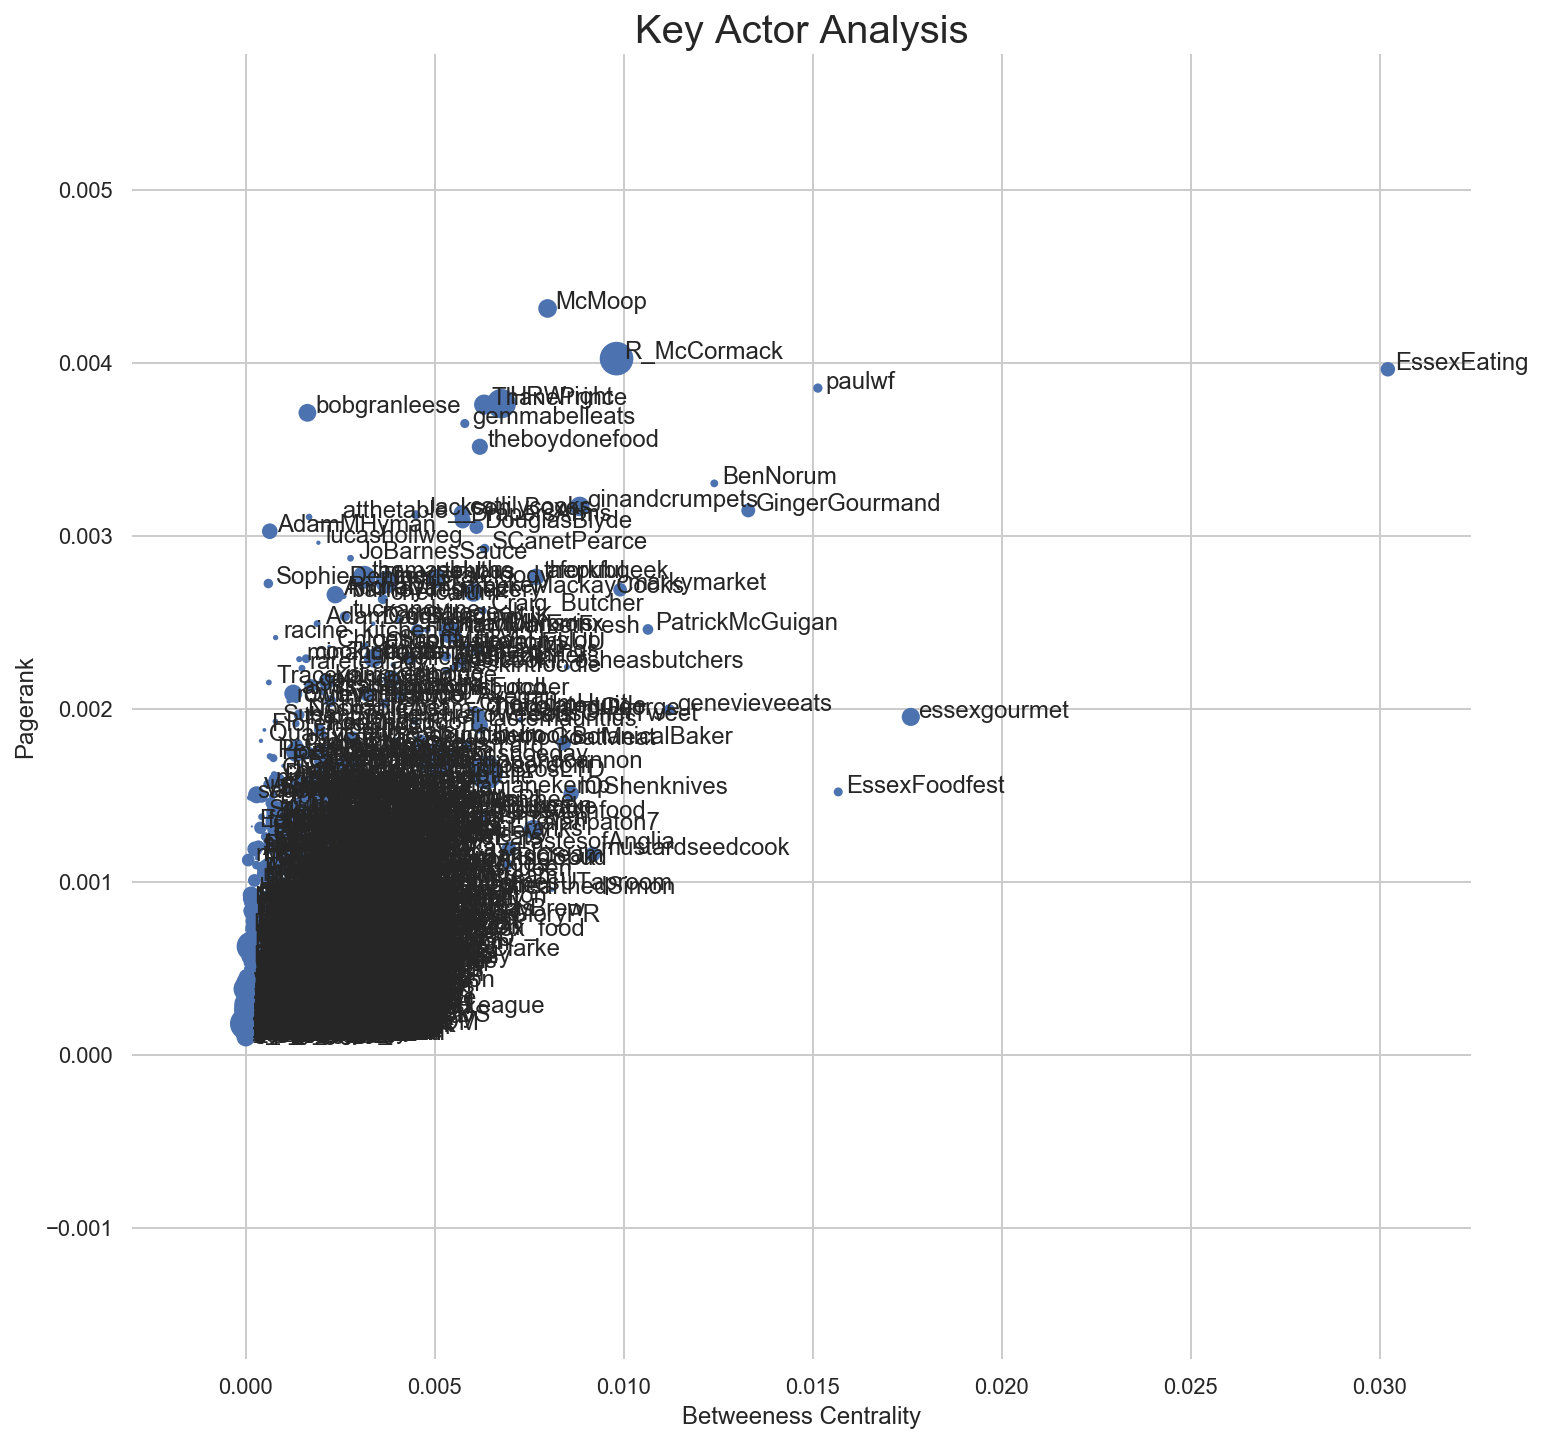

In [12]:
# plot_actor_analysis(data_ao)
# plot_actor_analysis(data_hd)
# plot_actor_analysis(data_ml)
# plot_actor_analysis(data_cq)
plot_actor_analysis(data_foodurchin)